In [397]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import numpy as np
import math
import preprocessing

In [319]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

## Importing data

In [135]:
start = datetime.datetime(2010, 8, 8)
end = datetime.datetime(2019, 8, 8)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-02,206.429993,201.630005,205.529999,204.020004,40862100.0,203.247772
2019-08-05,198.649994,192.580002,197.990005,193.339996,52393000.0,192.608185
2019-08-06,198.070007,194.039993,196.309998,197.000000,35824800.0,196.254333
2019-08-07,199.559998,193.820007,195.410004,199.039993,33364400.0,198.286606
2019-08-08,203.529999,199.389999,200.199997,203.429993,27009500.0,202.659988


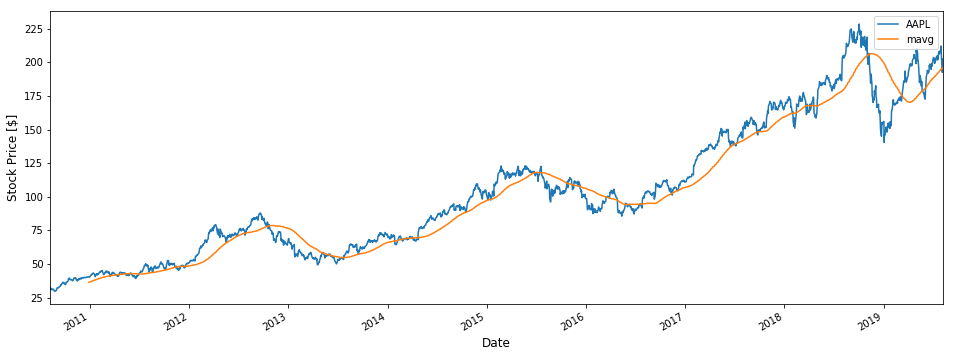

In [398]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (16,6))
plt.grid(True)
plt.ylabel('Stock Price [$]',fontsize = 12)
plt.xlabel('Days',fontsize = 12)


close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

plt.show()

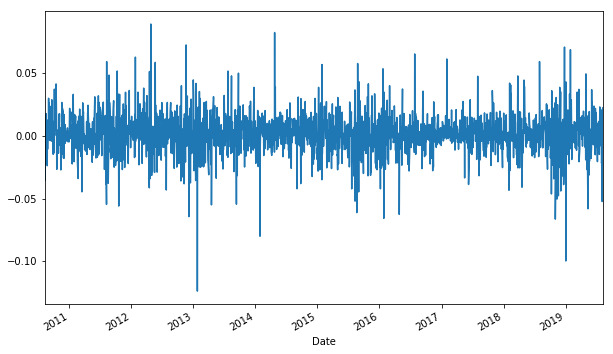

In [137]:
rets = close_px / close_px.shift(1) - 1
plt.figure(figsize = (10,6))
rets.plot(label='return')

## Analysing competitor stocks

In [138]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [139]:
retscomp = dfcomp.pct_change() #Percentage change - how much the price changes compared to the previous day which defines returns

corr = retscomp.corr()

Text(0, 0.5, 'Returns GE')

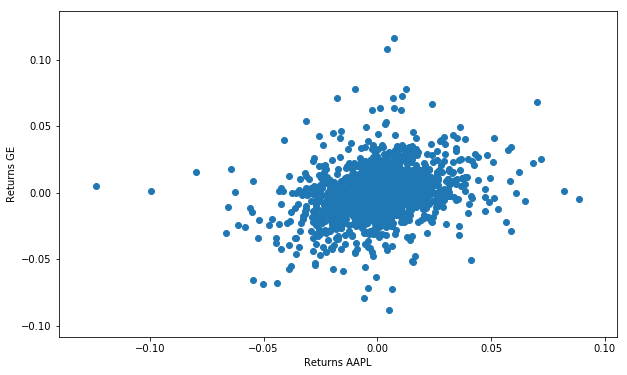

In [140]:
plt.figure(figsize = (10,6))
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E58842AEF0>,
      dtype=object)

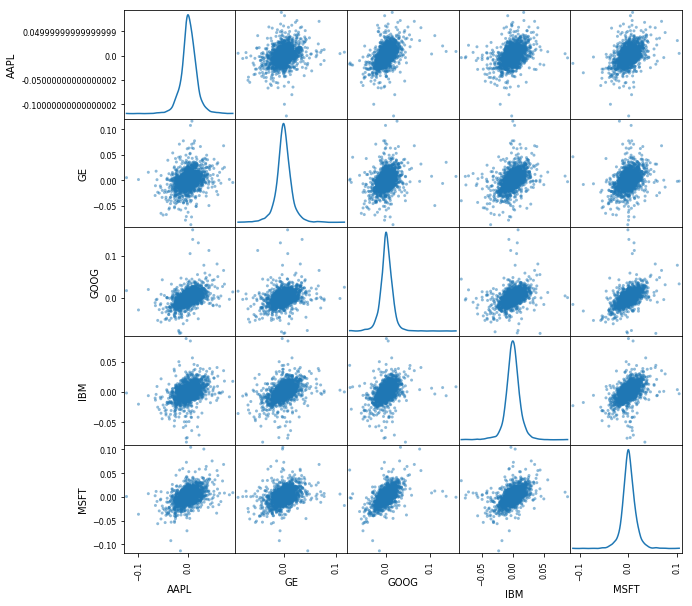

In [141]:
#scatter matrix with Kernel density Estimates at diagonal
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))

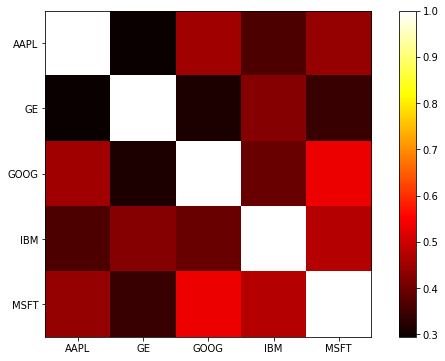

In [142]:
#heatmap - visualizing correlations
plt.figure(figsize = (10,6))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

## Stocks Returns Rate and Risk

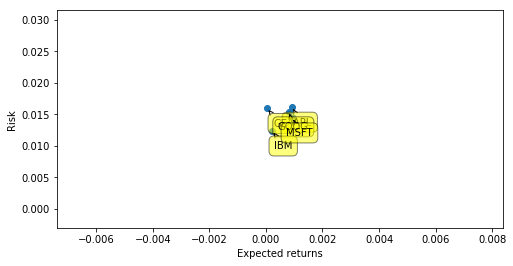

In [145]:
plt.figure(figsize = (8,4))
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')

for label, x, y in list(zip(retscomp.columns, retscomp.mean(), retscomp.std())):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

## Predicting Stocks Price

In [146]:
# adding faetures: High Low Percentage and Percentage Change

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0

In [204]:
# Drop missing value
dfreg.fillna(method = 'ffill', inplace=True)

# shift time (prediccting based on n_shift-previous day)
n_shift = 2

#Arranging X and y - shifting
X_0 = np.array(dfreg)
y_0 = np.array(dfreg['Adj Close'])

y = y_0[n_shift::]
X = X_0[:-n_shift]

from sklearn.preprocessing import scale
# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)

# train test split without shuffling - so there will be no future data in training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)


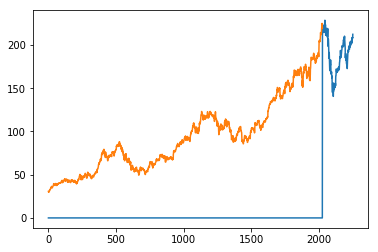

In [396]:
#cheking that we cut the last part of data
plt.plot(np.concatenate((np.zeros_like(y_train),y_test)))
plt.plot(y_train)

In [207]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Qubic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [211]:
# Linear regression
clfreg = LinearRegression()
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Qubic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [212]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print(confidencereg)
print(confidencepoly2)
print(confidencepoly3)
print(confidenceknn)

-10004.785406077663
-0.0552337601685049
0.6740054605813123
-2.5041860376886773


### Let's look at data prediction

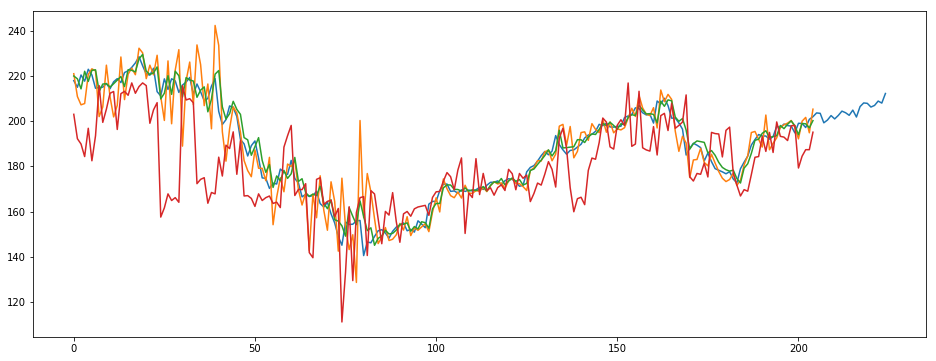

In [395]:
plt.figure(figsize = (16,6))
plt.plot(y_test)
plt.plot(clfpoly3.predict(X_test)[:-20])
plt.plot(clfpoly2.predict(X_test)[:-20])
plt.plot(clfknn.predict(X_test)[:-20])

we can see that except for KNN every other method does pretty well - in case we don't consider last few days outliers

## Expanding X by including previous days

### Breaking time data into equivalent parts

In [290]:
def breaking(X,y,t_length):
    
    max_length = (X.shape[0]//t_length)*t_length
    X_new = X[0:max_length,::]
    y_out = y[t_length:max_length]
    
    # arranging new matrix
    X_flat = np.zeros(t_length)
    for i in range(len(y_out)):
        new_row = np.matrix.flatten(X[i:i+t_length])
        X_flat = np.concatenate((X_flat,new_row))
        
    X_flat = X_flat[t_length::]
    
    n_cols = t_length*X.shape[1]
    n_rows = len(X_flat)//(t_length*X.shape[1])
    X_out = X_flat.reshape((n_rows,n_cols))
    
    return(X_out,y_out)

def weights(w,row_length,t_length):
    out = np.ones(row_length*t_length)
    
    for i in range(t_length):
        out[i*row_length:(i+1)*row_length] = out[i*row_length:(i+1)*row_length]*w[i]
        
    return(out)


In [342]:
prices = np.array(dfreg['Adj Close'])
X_data = np.array(dfreg)

X,y = breaking(X_data,prices,10)


# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)

w1 = weights(np.linspace(0.05,1,10),X_data.shape[1],10)
#print(w1)
X = X*w1

# train test split without shuffling - so there will be no future data in training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:180: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


### Plot of weights decrease in X proportional to distance from prediction day

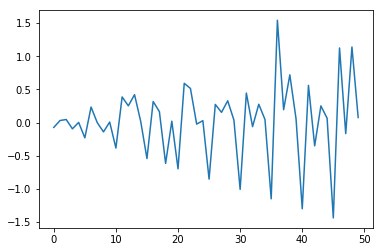

In [343]:
plt.plot(X[10])

In [374]:
# Linear regression
clfreg = LinearRegression()
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Qubic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

# Random forest
clfforest = regr = RandomForestRegressor(n_estimators = 50)
clfforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [375]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidenceforest = clfforest.score(X_test, y_test)

print('linear regression ',confidencereg)
print('polynomial 2 order ',confidencepoly2)
print('polynomial 3 order  ',confidencepoly3)
print('KNN ',confidenceknn)
print('Random forest ',confidenceforest)

linear regression  -3501.8660942503852
polynomial 2 order  -14.42759492613558
polynomial 3 order   -20.017519614631855
KNN  0.34252804808490056
Random forest  0.8572053050992381


### Plotting the prediced prices

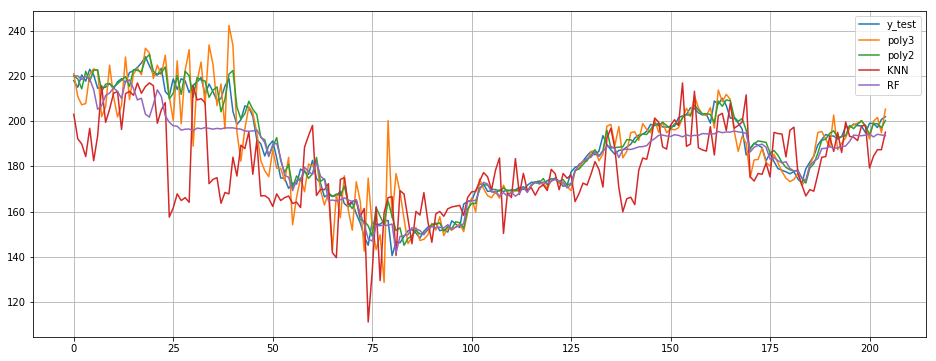

In [382]:
plt.figure(figsize = (16,6))

plt.plot(y_test[:-20])
plt.plot(clfpoly3.predict(X_test)[:-20])
plt.plot(clfpoly2.predict(X_test)[:-20])
plt.plot(clfknn.predict(X_test)[:-20])
plt.plot(clfforest.predict(X_test)[:-20])

legen = ['y_test','poly3','poly2','KNN','RF']
plt.legend(legen)
plt.grid(True)

#### Prediction and actual price difference

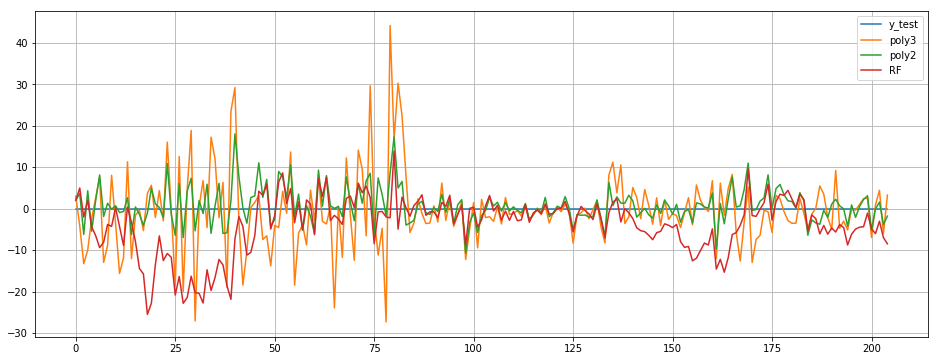

In [392]:
plt.figure(figsize = (16,6))

plt.plot(y_test[:-20] - y_test[:-20])
plt.plot(clfpoly3.predict(X_test)[:-20] - y_test[:-20])
plt.plot(clfpoly2.predict(X_test)[:-20] - y_test[:-20])
#plt.plot(clfknn.predict(X_test)[:-20] - y_test[:-20])
plt.plot(clfforest.predict(X_test)[:-20] - y_test[:-20])

legen = ['y_test','poly3','poly2','RF']
plt.legend(legen)
plt.grid(True)